In [56]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [58]:
def get_yahoo_data(ticker, start_date, end_date):
    
    """
    Download yahoo finance data with yfinance module for a given ticker symbol.

    Parameters:
        tkr (str): Ticker symbol for which yahoo finance data is downloaded.
        start_date (str): Start date for dataset to be dowloaded. 
        end_date (str): End date for dataset to be downloaded.

    Returns:
        pandas.DataFrame: DataFrame with the downloaded data for given ticker.
    """
    
    try:
        df1 = yf.download(ticker, start_date, end_date)
        if df1.empty:
            raise ValueError("No data returned from Yahoo Finance.")
        return df1
    except yf.YFinanceError as e:
        print(f"Error occurred while retrieving data: {e}")
        return None

In [59]:
def calc_ema(span1, span2, df):
    
    """
    Calculate exponential moving averages (EMA) for a given column in a DataFrame.

    Parameters:
        column_name (str): The name of the column for which moving averages are calculated.
        df (pandas.DataFrame): The DataFrame containing the data.
        span1 (int): The span for the first EMA.
        span2 (int): The span for the second EMA.

    Returns:
        pandas.DataFrame: DataFrame with the calculated EMAs added as columns.
    """
    
    df['EMA_A'] = df['Close'].ewm(span=span1, adjust=False).mean()
    df['EMA_B'] = df['Close'].ewm(span=span2, adjust=False).mean()
    return df

In [60]:
# def cross_direction(df):
    
#     """
#     Tracks when the EMA_A crosses above or below  EMA_B Exponential Moving Average.
#     The cross direction is added to a new column called 'Cross_Direction'
#     """
    
#     crossed_above = (df['EMA_A'] > df['EMA_B']) & (df['EMA_A'].shift(1) < df['EMA_B'].shift(1))
#     df.loc[crossed_above, 'Cross_Direction'] = 'crossed up'
#     condition_met = df[df['Cross_Direction'].notna()]

#     crossed_below = (df['EMA_A'] < df['EMA_B']) & (df['EMA_A'].shift(1) > df['EMA_B'].shift(1))
#     df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'
#     condition_met = df[df['Cross_Direction'].notna()]
    
#     return condition_met

In [61]:
def cross_direction(df):
    
    """
    Tracks when the EMA_A crosses above or below  EMA_B Exponential Moving Average.
    The cross direction is added to a new column called 'Cross_Direction'
    """
    
    crossed_above = (df['EMA_A'] > df['EMA_B']) & (df['EMA_A'].shift(1) < df['EMA_B'].shift(1))
    df.loc[crossed_above, 'Cross_Direction'] = 'crossed up'
    condition_met = df[df['Cross_Direction'].notna()]

    crossed_below = (df['EMA_A'] <= df['EMA_B']) & (df['EMA_A'].shift(1) > df['EMA_B'].shift(1))
    df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'
    condition_met = df[df['Cross_Direction'].notna()]
    
    return condition_met

In [62]:
def initialize_investment(df):
    """
    Find the first crossed up event and set the initial cost.
    The ticker closing price is set to initial cost as init_cost.
    """

    for index, row in df.iterrows():
        if row['Cross_Direction'] == 'crossed up':
            init_cost = row['Close']  # Set init_cost to the price at the first crossed up event
            cash = init_cost  # Set cash to the initial cost
            # print("                     Your initial investment is: $ {}".format(init_cost))
            # print("The cash value is set to the initial investment: $ {}".format(cash))
            return init_cost, cash  # Return the values once 'crossed up' is found

In [63]:
def calc_profit(df, set_last_signal):

    init_cost = 0
    cash = init_cost 
    shares_owned = 0
    prev_crossed_above = False
    transactions = []
    
    df.iloc[-1, df.columns.get_loc('Cross_Direction')] = set_last_signal # Update DataFrame with the last signal

    for index, row in df.iterrows():
        if row['Cross_Direction'] == 'crossed up' and prev_crossed_above == False:  # Check if the Cross_Direction column is 'crossed up'
            cash -= row['Close']  # Buy one share. Deduct purchase price from cash
            transactions.append(('Buy', index, row['Open'], row['Close'], row['Close'], cash))
            prev_crossed_above = True

        elif row['Cross_Direction'] == 'crossed down' and prev_crossed_above:  # Check if the Cross_Direction column is 'crossed down':
            cash += row['Open'] # Sell one share. Add sale price to cash
            transactions.append(('Sell', index, row['Open'], row['Close'], row['Open'], cash))
            # transactions.append(('Sell', index, row['Open'], row['Close'], row['Open'], row['Open']))  # Record 'Open' price as sell price, and keep the cash value unchanged
            prev_crossed_above = False

        else:
            pass

    last_signal_as_cash = cash
    transactions_df = pd.DataFrame(transactions, columns=['Action', 'Date', 'Open', 'Close', 'Price', 'Cash'])
    
    return transactions_df, last_signal_as_cash # returns a new dataframe for transactions and also returns the last cash value as last_signal_as_cashh

In [64]:
def investment_performance(ticker, initial_investment, portfolio_value):

    """
    Outputs the investment performance.  Performance is claculated by taking the 
    initial_investment (stock puchase price) and subtracting the portfolio_value.
    Portfolio value is the last crossed_down price from
    the calc_proffit function retruned.
    """

    profit_loss = portfolio_value - initial_investment
    # percent = (profit_loss / initial_investment) * 100
    percent = (portfolio_value / initial_investment) * 100

    result_string = "\n"
    result_string += '                             Results For Ticker:   {}\n'.format(ticker)
    result_string += '                             Initial Investment: $ {}\n'.format(round(initial_investment, 1))
    result_string += "                          Final Portfolio Value: $ {}\n".format(int(portfolio_value))
    # result_string += "                                    Profit/Loss: $ {}\n".format(round(profit_loss, 1))
    result_string += "                                        Percent:   {:.1f} %\n\n".format(percent)

    return result_string

In [65]:
def plot_graph(ticker_data, transactions):
    plt.figure(figsize=(16, 8))
    plt.plot(ticker_data.index, ticker_data['Close'], label='Close Price', color='gray')
    plt.gca().set_facecolor('black')  # Set the background color to black
    # plt.plot(ticker_data.index, ticker_data['EMA_A'], label='EMA_A', linestyle='--')
    # plt.plot(ticker_data.index, ticker_data['EMA_B'], label='EMA_B', linestyle='--')
    plt.scatter(ticker_data.index[ticker_data['Cross_Direction'] == 'crossed up'], 
                    ticker_data['Close'][ticker_data['Cross_Direction'] == 'crossed up'], 
                    marker='^', color='lightgreen', s=50, label='Buy')

    plt.scatter(ticker_data.index[ticker_data['Cross_Direction'] == 'crossed down'], 
                ticker_data['Close'][ticker_data['Cross_Direction'] == 'crossed down'], 
                marker='v', color='red', label='Sell')
    plt.title('Closing Price and EMAs for {}'.format(ticker))
    plt.xticks(ticker_data.index[::30], ticker_data.index[::30].strftime('%Y-%m-%d'), rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [66]:
# signal.tail()

In [67]:
# ticker_data.tail()


[*********************100%%**********************]  1 of 1 completed


                             Results For Ticker:   ^gspc
                             Initial Investment: $ 4546.5
                          Final Portfolio Value: $ -3807
                                        Percent:   -83.7 %




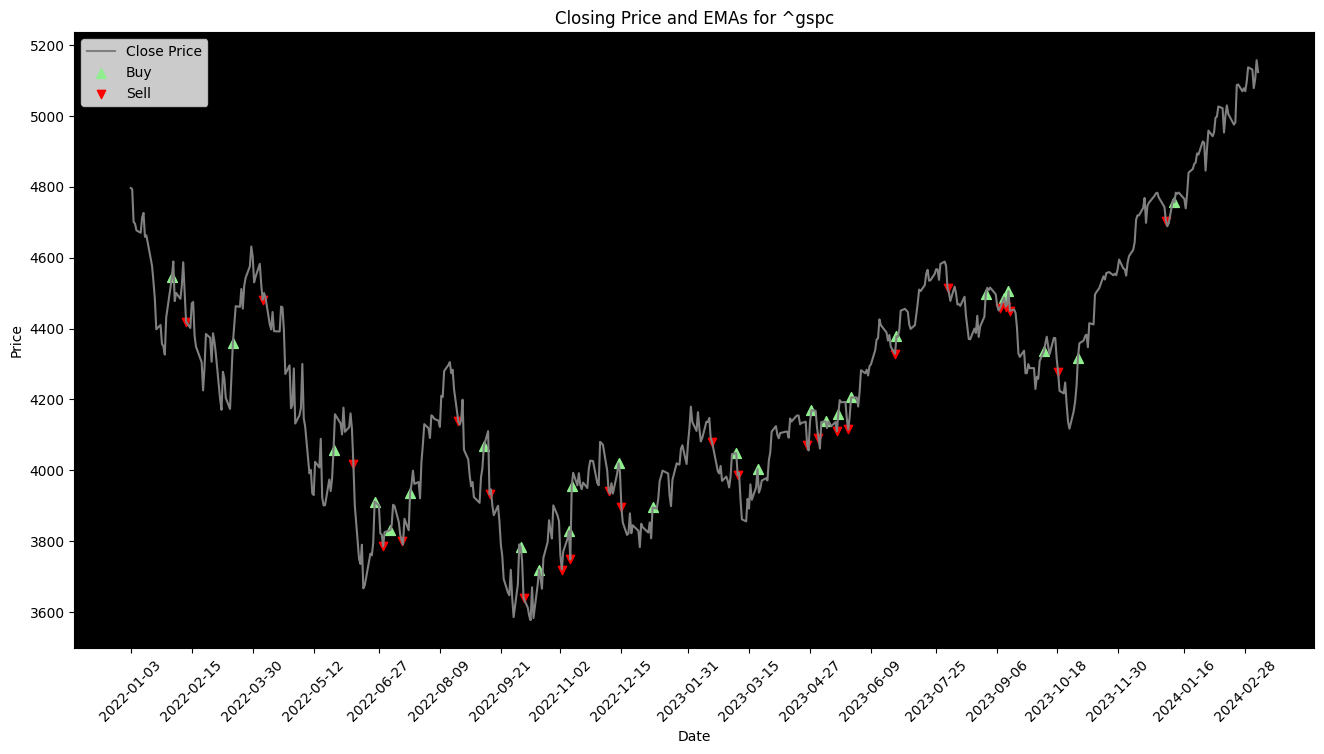

[*********************100%%**********************]  1 of 1 completed



                             Results For Ticker:   skyy
                             Initial Investment: $ 93.5
                          Final Portfolio Value: $ -72
                                        Percent:   -77.6 %




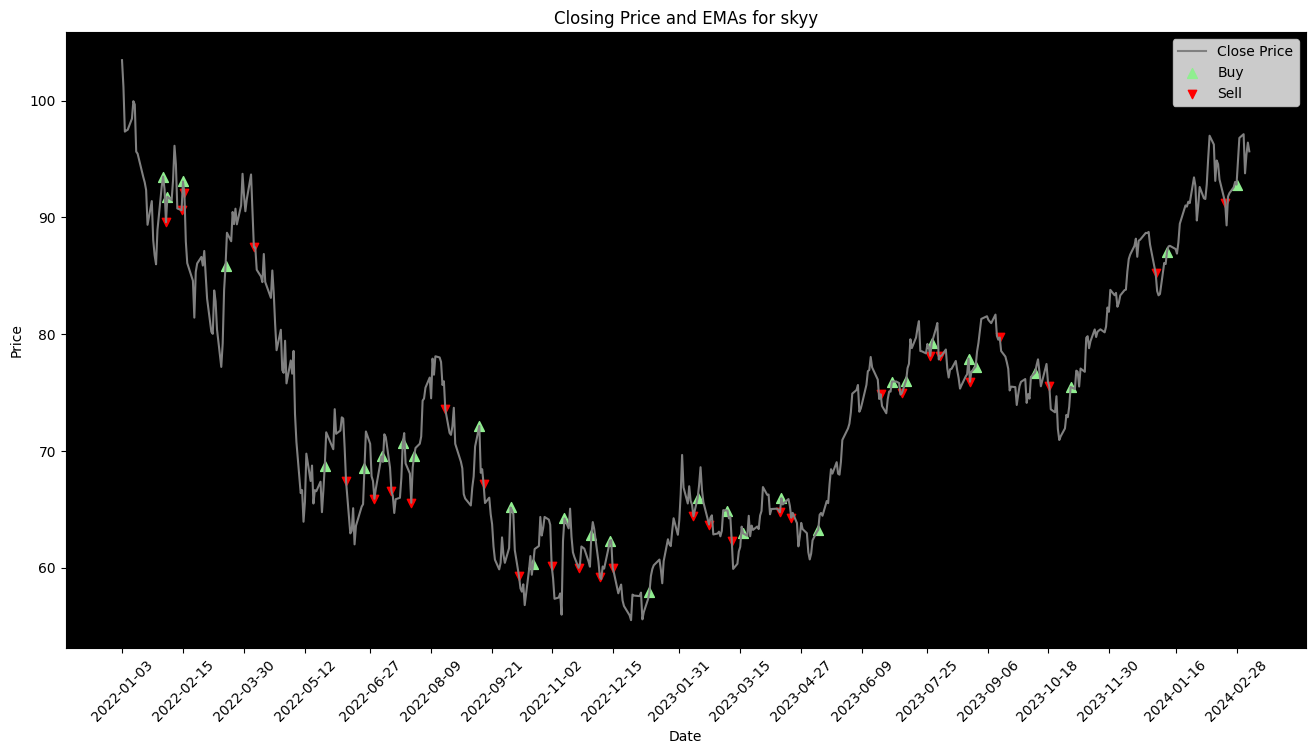

[*********************100%%**********************]  1 of 1 completed



                             Results For Ticker:   arkw
                             Initial Investment: $ 93.3
                          Final Portfolio Value: $ -68
                                        Percent:   -73.4 %




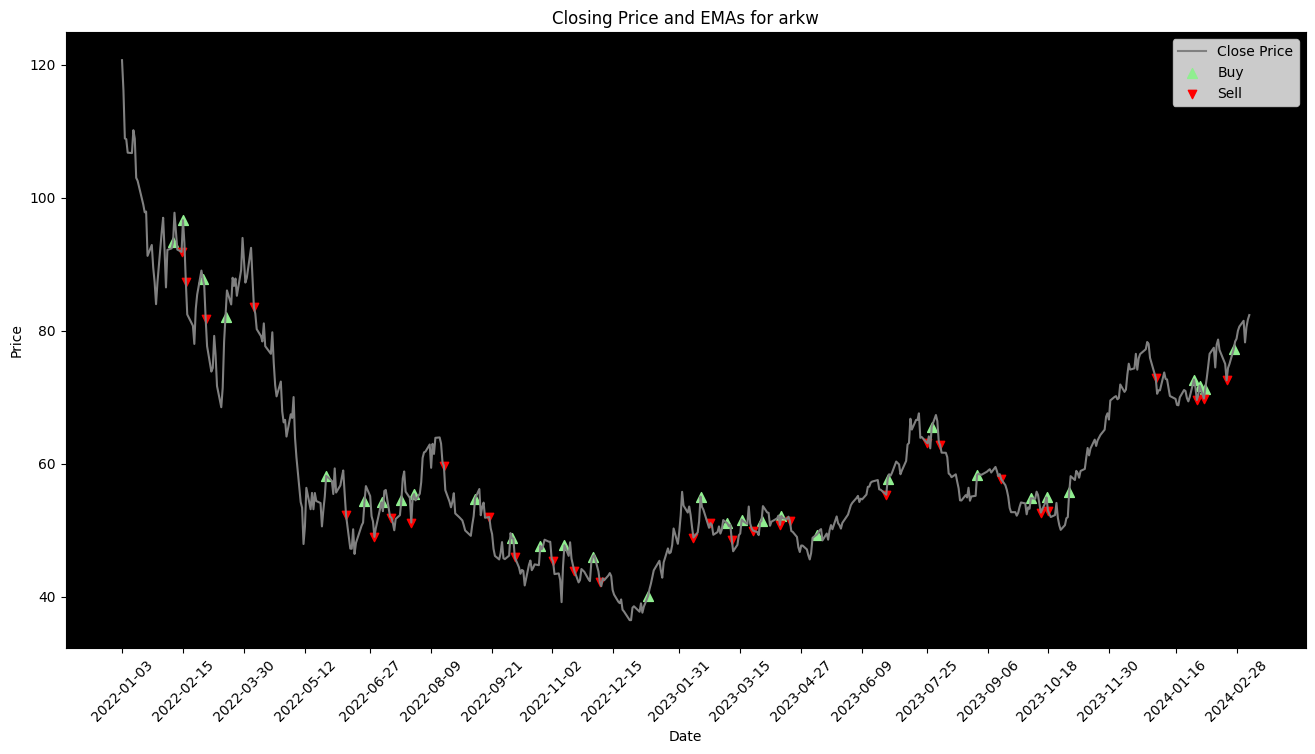

[*********************100%%**********************]  1 of 1 completed



                             Results For Ticker:   xlk
                             Initial Investment: $ 162.0
                          Final Portfolio Value: $ -134
                                        Percent:   -82.9 %




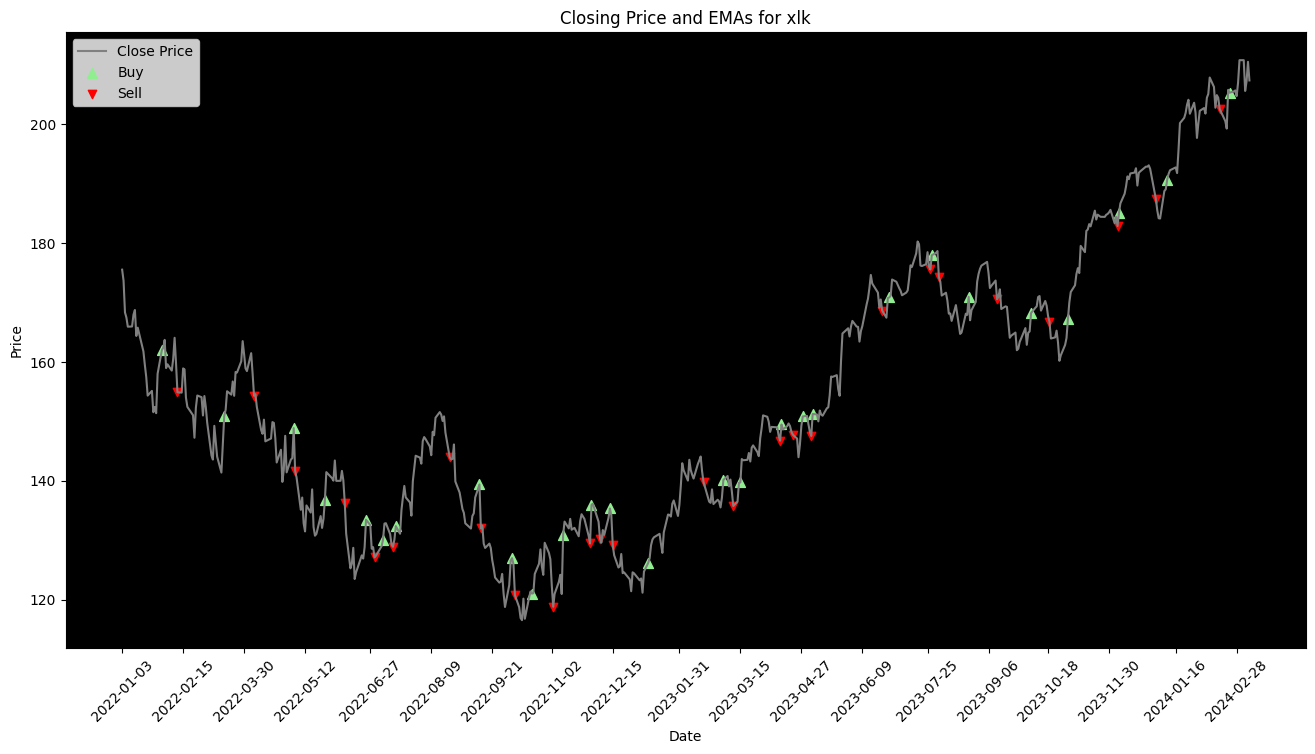

[*********************100%%**********************]  1 of 1 completed



                             Results For Ticker:   ffty
                             Initial Investment: $ 39.3
                          Final Portfolio Value: $ -21
                                        Percent:   -54.7 %




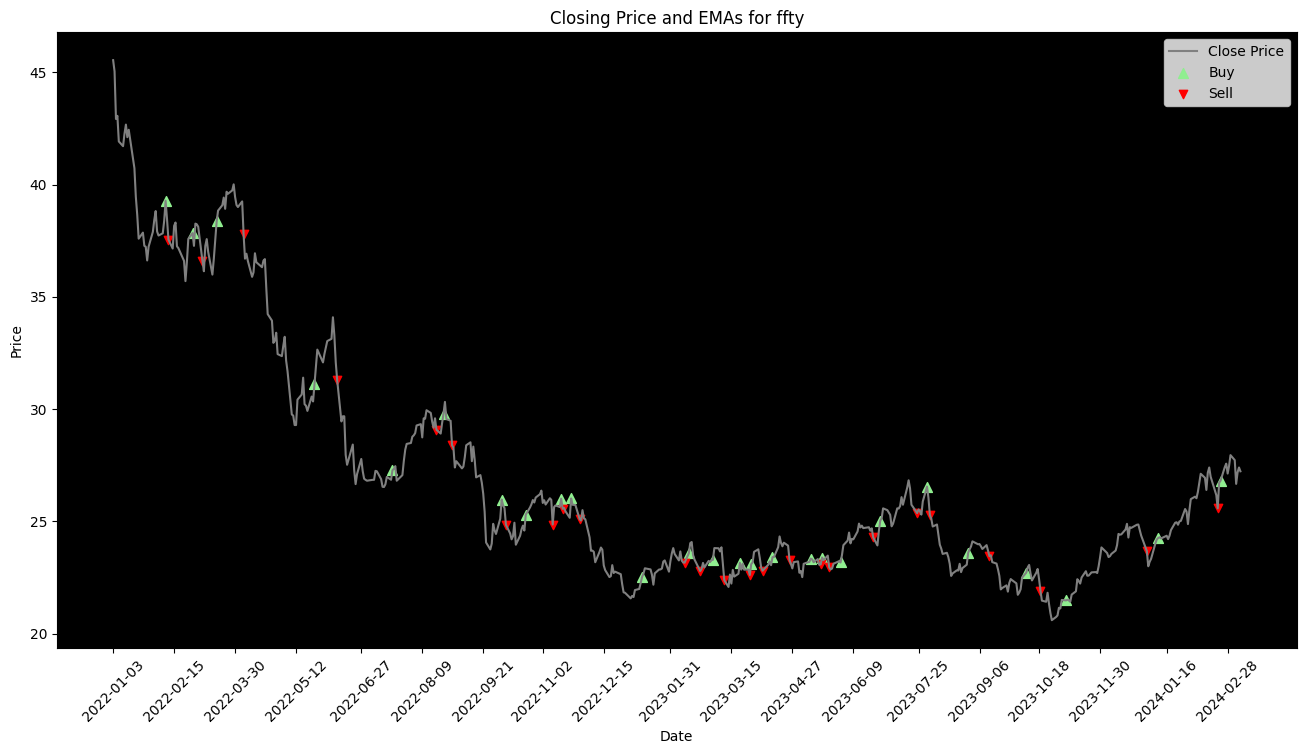

[*********************100%%**********************]  1 of 1 completed



                             Results For Ticker:   wfstx
                             Initial Investment: $ 14.8
                          Final Portfolio Value: $ -11
                                        Percent:   -76.0 %




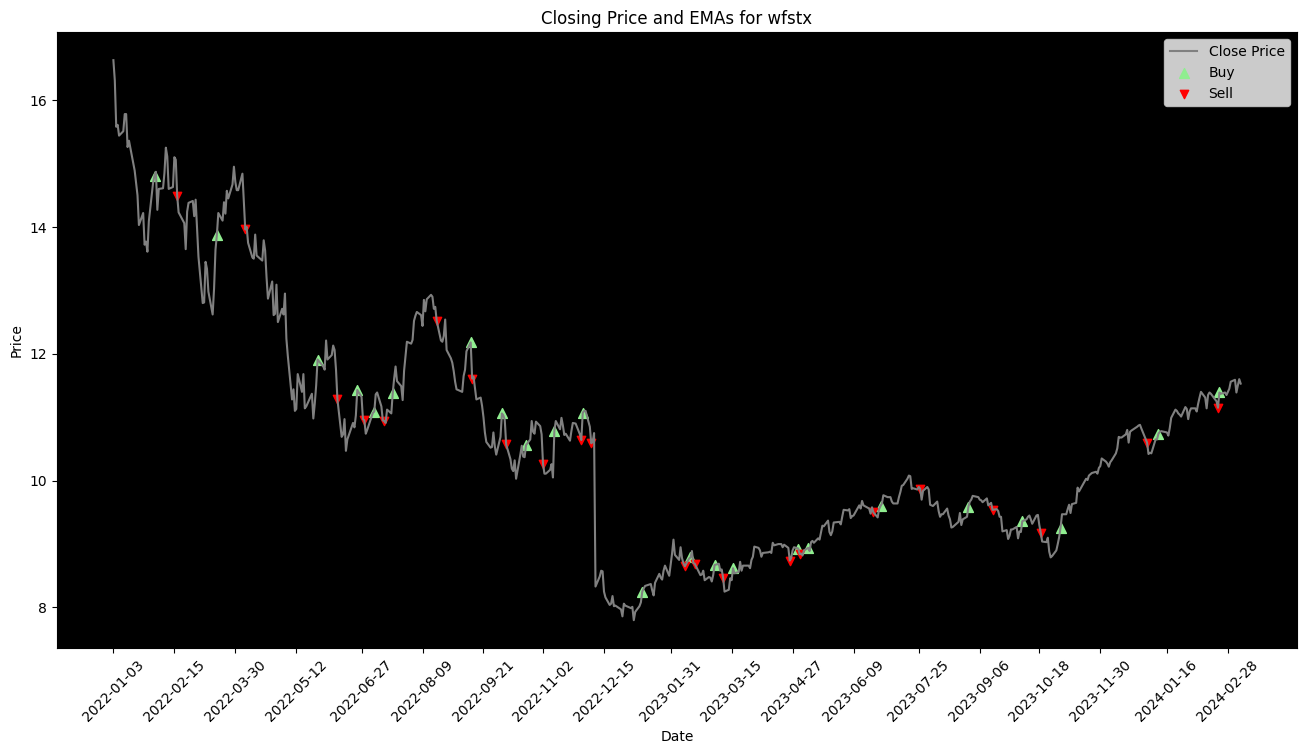

In [68]:
# ticker_list = [ 'ai','arm','arkg','cflt','crwd','snow','dkng','dlo','ionq','joby',
#                'lazr','glbe','fubo','hcp','path','pltr','rblx','sofi','tsla','ttd','vuzi']
# ticker_list = ['btc-usd', 'eth-usd', 'doge-usd', 'shib-usd', 'sol-usd', 'ada-usd', 'cro-usd', 'xlm-usd', 'xlm-usd', 'poly-usd', 'avax-usd', 'xrp-usd', 'mana-usd', 'lrc-usd', 'matic-usd', 'link-usd']
ticker_list = ['^gspc', 'skyy', 'arkw', 'xlk', 'ffty', 'wfstx']

for ticker in ticker_list:
    start_date = '2022-01-01'
    end_date = '2024-03-11'

    dataset = get_yahoo_data(ticker, start_date, end_date)

    ticker_data = pd.DataFrame(dataset)
    calc_ema(5, 7, ticker_data)
    signal = cross_direction(ticker_data)


    result = initialize_investment(ticker_data)

    set_last_signal = ''#'crossed down' # comment out 'crossed down' if you don't want to force the sell
    trans = calc_profit(ticker_data, set_last_signal)

    initial_inveetment = result[0]
    last_signal_from_calc_profit = trans[1]
    performance_output = investment_performance(ticker, initial_inveetment, last_signal_from_calc_profit)

    print(performance_output)
    plot_graph(ticker_data, trans[0])
    



In [69]:
trans

(   Action       Date   Open  Close  Price       Cash
 0     Buy 2022-02-01  14.81  14.81  14.81 -14.810000
 1    Sell 2022-02-17  14.49  14.49  14.49  -0.320001
 2     Buy 2022-03-17  13.88  13.88  13.88 -14.200001
 3    Sell 2022-04-06  13.96  13.96  13.96  -0.240001
 4     Buy 2022-05-27  11.91  11.91  11.91 -12.150001
 5    Sell 2022-06-10  11.28  11.28  11.28  -0.870001
 6     Buy 2022-06-24  11.43  11.43  11.43 -12.300001
 7    Sell 2022-06-29  10.95  10.95  10.95  -1.350001
 8     Buy 2022-07-06  11.09  11.09  11.09 -12.440001
 9    Sell 2022-07-13  10.94  10.94  10.94  -1.500002
 10    Buy 2022-07-19  11.38  11.38  11.38 -12.880002
 11   Sell 2022-08-19  12.52  12.52  12.52  -0.360002
 12    Buy 2022-09-12  12.18  12.18  12.18 -12.540002
 13   Sell 2022-09-13  11.61  11.61  11.61  -0.930002
 14    Buy 2022-10-04  11.06  11.06  11.06 -11.990003
 15   Sell 2022-10-07  10.57  10.57  10.57  -1.420003
 16    Buy 2022-10-21  10.56  10.56  10.56 -11.980003
 17   Sell 2022-11-02  10.26